**ARIES PROJECT**;
NEURAL STYLE TRANSFER
-Pratham, Saksham, Somesh, Archit


In this project we will try to compute the mixture of 2 images namely style image and content image using the property of feature extraction in CNN. This algorithm mesmerises us since there is no training set needed to train the model that makes it one of the unique projects. The official documentation of NST by tensorflow is used as a refernce

In [145]:
#importing files required for our algorithm-os for connecting to system, tensowflow(prominent tool for dl)
#,compressed models from tensorflow_hub
import os
import tensorflow as tf

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

Using display function from ipython, importing matplotlib for plotting graphs and pictures, setting height width of plan,importing numpy and other tools required to keep check of our model

In [146]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (14, 14)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

Since we have to first input image and then convert to tensor(for our tensowflow models to run),as well as tensor to imaage since our output is image, we define a function that converts tensors to image done through converting it into numpy array and also asserting to have proper dimensions 

In [147]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Uploading images through paths, therefore making a variable that stores path, then creating a function that converts path to image preprocessing it to float tensor which can be further used by our trained model, and also limiting the pixels of the image to prevent any errors.

In [148]:
content_path = '/content/final1.jpg'
style_path = '/content/final2.jpg'

In [149]:
def load_img(path_to_img):
  #converting path to readable format
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Just to check that our images have been uploaded and successfully preprocessed, we try to plot it through a package called matplotlib, defining a function that plots that image(RGB), 3 dimensional ,

In [150]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

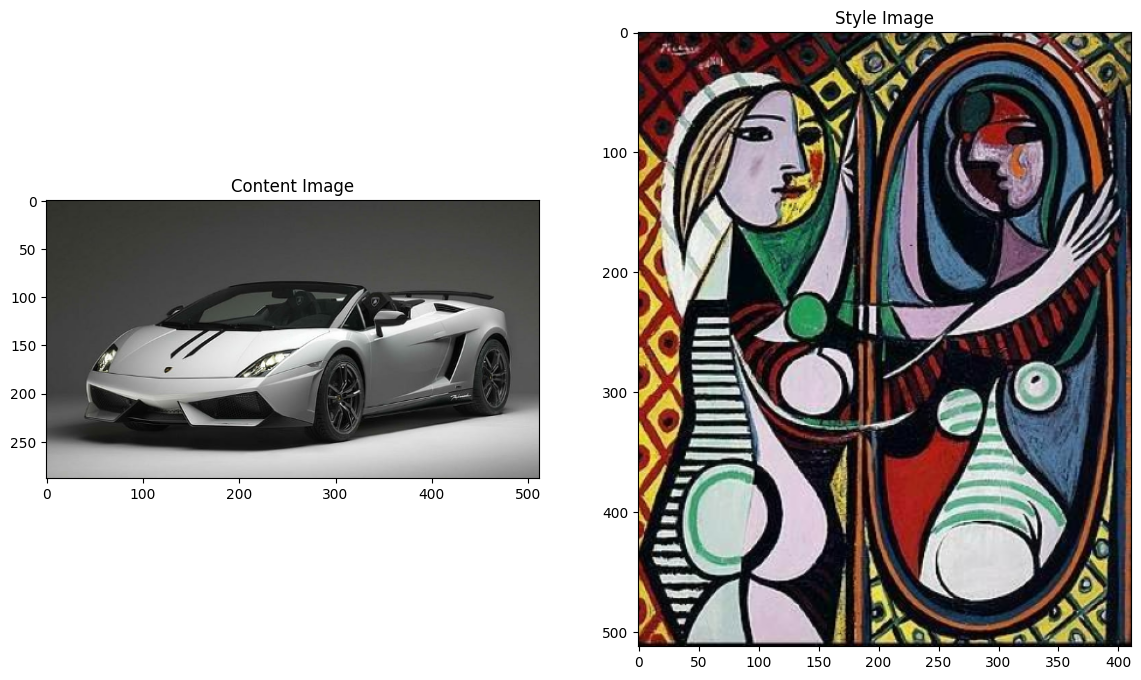

In [151]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [152]:
type(content_image)

tensorflow.python.framework.ops.EagerTensor

Now its time to import the vgg model, we first preprocess it, resize it according to the input of the vgg19 model and also calculating the probability of what our content image is.. as stated in predicted_top_5 

In [153]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [154]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('sports_car', 0.8421843),
 ('racer', 0.10478829),
 ('convertible', 0.035195716),
 ('car_wheel', 0.0141223185),
 ('grille', 0.0022938978)]

Now we can see what layers our vgg model has, 
we can clearly see 5 hidden layers+ input layer, each comprising of 2 conv layers and then a pool layer,

In [155]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_18
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [156]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Creating a function that calculates the output of the hidden layers of our vgg model, so we can use it in our cost function, printing the outputs of all the blocks , and defining a style_extractor that keeps note of every output of style layers

In [157]:
def vgg_layers(layer_names):
 
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [158]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 411, 64)
  min:  0.0
  max:  814.9363
  mean:  29.665184

block2_conv1
  shape:  (1, 256, 205, 128)
  min:  0.0
  max:  4739.8047
  mean:  206.16756

block3_conv1
  shape:  (1, 128, 102, 256)
  min:  0.0
  max:  7765.1104
  mean:  231.80544

block4_conv1
  shape:  (1, 64, 51, 512)
  min:  0.0
  max:  22172.633
  mean:  725.9973

block5_conv1
  shape:  (1, 32, 25, 512)
  min:  0.0
  max:  3900.323
  mean:  60.730034



Calculting gram matrix to calculate our style loss function, the formula is in our documentation and why we are using it is also provided there, we also made a class that helps us to calculate formula that returns content and style tensors 

In [159]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [160]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

Printing the values that we got for our image that we uploaded for each layer

In [161]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.00017775163
    max:  21025.43
    mean:  371.03394

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  154022.12
    mean:  13048.483

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  300876.62
    mean:  13381.59

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3790308.5
    mean:  202187.88

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  135121.64
    mean:  1686.6658

Contents:
   block5_conv2
    shape:  (1, 18, 32, 512)
    min:  0.0
    max:  1623.809
    mean:  15.566021


In [162]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [163]:
image = tf.Variable(content_image)

We now try to run gradient descent on our image, Optimised through adam with the generally used hyperparameters 

In [164]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Using the adam optiser for iterations

In [165]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

We would also define weights for style loss and content loss
J(total)=w(style)*J(style)+w(content)*J(content)

In [166]:
style_weight=1e-2
content_weight=1e3

Defining a function that calculates the total loss through all the functions we defined and also summing the loss for all layers.

In [167]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Now running one step of gradient descent i.e. Training the image, train_step, this is done through tape.gradient finding gradients and updating the image through apply_gradient

In [168]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Running this step 3 times and printing out the image 

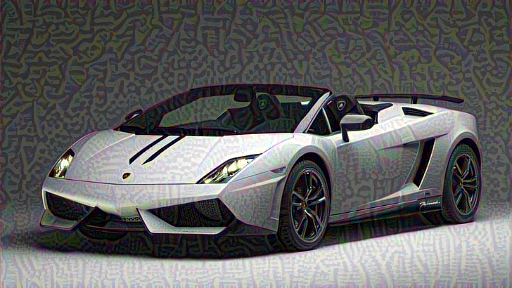

In [169]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Now we run the images for around 1,000 times (this gave us the best image of all the test cases we tried)
and printing the image every 100 steps i.e. for 1 epoch. And the end result image will be our output of model

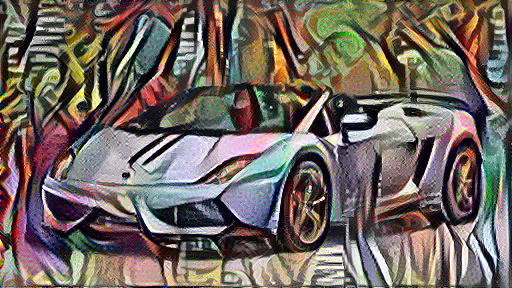

Train step: 1000
Total time: 51.8


In [170]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Now, when we run a model sometimes overfitting happens, and also image compression causes unwanted noise or disturbances present in the high-frequency components of a image that may affect our result image. To do this we use regularisation

We define a function that does high pass filtering(refering the high frequency of the image) around x axis and y axis and then comparing with the orginal and output image that we got, as we can see we need to improve the edges as shown in the graphs

In [171]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

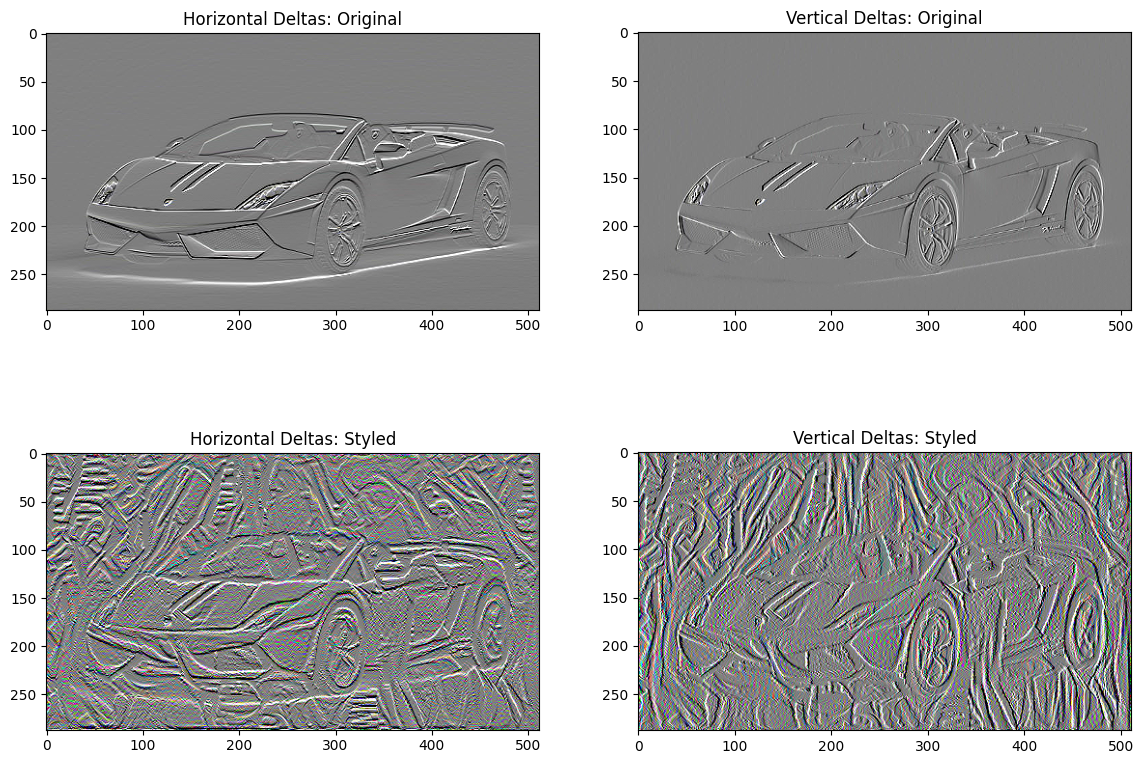

In [172]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

We can also use sobel filter as an edge detector and output as shown in the figures plotted through imshow function defined previously

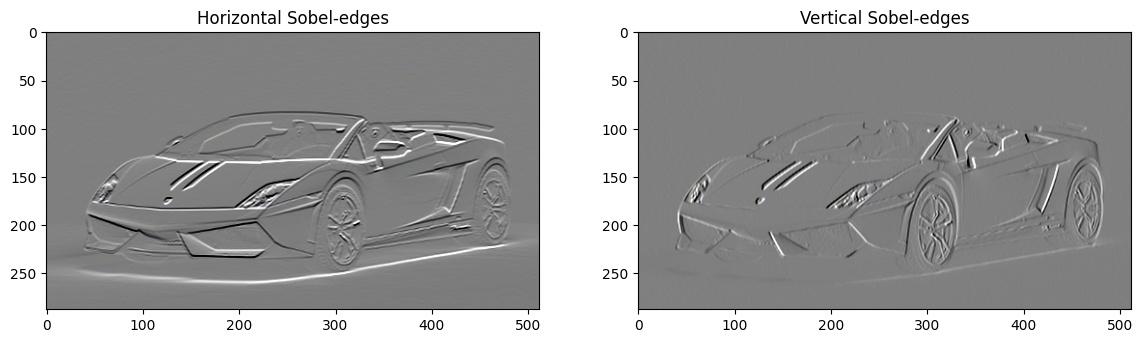

In [173]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

Now we calculate the total loss (loss in x and y )because of this high frequency and calculate the variation loss of our image by using the above functions we defined, we convert that loss into an array so that we can easily run it in our model and assumed a weight as well

In [174]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [175]:
total_variation_loss(image).numpy()

94320.05

In [176]:
tf.image.total_variation(image).numpy()

array([94320.05], dtype=float32)

In [177]:
total_variation_weight=30

Now we again assume a variable image and then while running gardient descant we add an extra variation_loss in the loss function that will improve our accuarcy in the train_step and rest is same as we did before

In [178]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [179]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

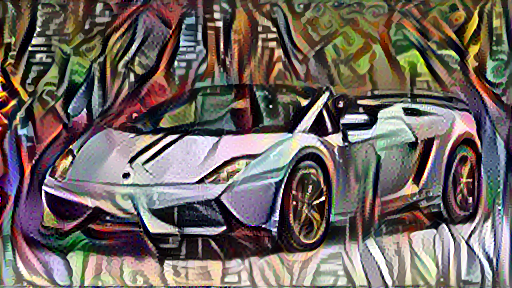

Train step: 1000
Total time: 53.0


In [180]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

We can download the file as well if you guys want you can uncomment if you want to

In [181]:
# file_name = 'stylized-image.png'
# tensor_to_image(image).save(file_name)

# try:
#   from google.colab import files
# except ImportError:
#    pass
# else:
#   files.download(file_name)

Thank you if you have reached till here, we are still developing on this project to further improve the edges also even try to retain as much features of the content image as well enhance it with the styles of style image. We have tried to make this project as crisp as possible and if possible in the next few days we will also have a website that will output you the image. You can try running some of your images as well, we have gathered many style images and chosen the best ones.